In [1]:
import sys, os
sys.path.insert(0, '..')

In [2]:
import residual2vec as rv
import numpy as np
import pandas as pd
from scipy import sparse
import networkx as nx
from torch.utils.data import DataLoader
import torch


import graph_embeddings
from models.crosswalk import Crosswalk

from scipy import sparse
import seaborn as sns
import matplotlib.pyplot as plt



import warnings
warnings.filterwarnings("ignore")

Using GPU: cuda:0


2022-09-09 17:37:59.769910: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-09 17:37:59.770960: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [3]:
window_length = 5
num_walks = 10
dim = 128
walk_length = 80
NUM_WORKERS = 4

# POLBOOKS DATASET

In [4]:
DATA_FILE = '../data/polbooks.gml'
G = nx.read_gml(DATA_FILE)
G = nx.relabel.convert_node_labels_to_integers(G, first_label=0, ordering='default')

nodes = G.nodes(data=True)
labels, group_ids = np.unique([n[1]['value'] for n in nodes], return_inverse=True)

A = nx.adjacency_matrix(G).asfptype()
deg = np.array(A.sum(axis=1)).reshape(-1)
G = nx.from_scipy_sparse_matrix(A)
models, embs = {}, {}

In [5]:
from residual2vec.word2vec import Word2Vec
k = "degree-unbiased"
model = rv.residual2vec_sgd(
    noise_sampler=rv.ConfigModelNodeSampler(),
    window_length=window_length,
    num_walks=num_walks,
    walk_length=walk_length
).fit(A)

adjusted_num_walks = np.ceil(
        num_walks
        * np.maximum(
            1,
            model.batch_size
            * model.miniters
            / (model.n_nodes * num_walks * walk_length),
        )
    ).astype(int)
d = rv.TripletSimpleDataset(
        adjmat=model.adjmat,
        group_ids=group_ids,
        num_walks=adjusted_num_walks,
        window_length=model.window_length,
        noise_sampler=model.sampler,
        padding_id=model.n_nodes,
        walk_length=model.walk_length,
        p=model.p,
        q=model.q,
        buffer_size=model.buffer_size,
        context_window_type=model.context_window_type,
    )
dataloader = DataLoader(
        d,
        batch_size=model.batch_size,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=True,
    )
models[k] = model
m = Word2Vec(vocab_size=A.shape[0] + 1, embedding_size=dim, padding_idx=A.shape[0])
embs[k] = models[k].transform(model=m, dataloader=dataloader)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 329/329 [00:00<00:00, 500.03it/s, loss=1.09]


In [6]:
k = "group-unbiased"
model = rv.residual2vec_sgd(
    noise_sampler=rv.SBMNodeSampler(
        group_membership=group_ids, window_length=window_length,
    ),
    window_length=window_length,
    num_walks=num_walks,
    walk_length=walk_length,
).fit(A)
adjusted_num_walks = np.ceil(
        num_walks
        * np.maximum(
            1,
            model.batch_size
            * model.miniters
            / (model.n_nodes * num_walks * walk_length),
        )
    ).astype(int)
d = rv.TripletSimpleDataset(
        adjmat=model.adjmat,
        group_ids=group_ids,
        num_walks=adjusted_num_walks,
        window_length=model.window_length,
        noise_sampler=model.sampler,
        padding_id=model.n_nodes,
        walk_length=model.walk_length,
        p=model.p,
        q=model.q,
        buffer_size=model.buffer_size,
        context_window_type=model.context_window_type,
    )
dataloader = DataLoader(
        d,
        batch_size=model.batch_size,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=True,
    )
models[k] = model
m = Word2Vec(vocab_size=A.shape[0] + 1, embedding_size=dim, padding_idx=A.shape[0])
embs[k] = models[k].transform(model=m, dataloader=dataloader)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 329/329 [00:00<00:00, 535.99it/s, loss=1.22]


In [7]:
embs["fairwalk"] = graph_embeddings.Fairwalk(window_length=window_length, num_walks=num_walks).fit(A).transform(dim=dim)
embs["fairwalk-group"] = graph_embeddings.Fairwalk(
    window_length=window_length, num_walks=num_walks, group_membership=group_ids
).fit(A).transform(dim=dim)
embs['GCN'] = graph_embeddings.GCN().fit(A).transform(dim=dim)
embs["gcn-doubleK"] = graph_embeddings.GCN(num_default_features=dim * 2).fit(A).transform(dim=dim)
embs["graphsage"] = graph_embeddings.GraphSage().fit(A).transform(dim=dim)
embs["graphsage-doubleK"] = graph_embeddings.GraphSage(num_default_features=dim * 2).fit(A).transform(dim=dim)
embs["gat"] = graph_embeddings.GAT(layer_sizes=[64, 256]).fit(A).transform(dim=dim)
embs["gat-doubleK"] = graph_embeddings.GAT(num_default_features=dim * 2).fit(A).transform(dim=dim)

embs['crosswalk'] = Crosswalk(group_membership=group_ids, window_length=window_length, num_walks=num_walks).fit(A).transform(dim=dim)

Using GCN (local pooling) filters...
Epoch 1/200
1/1 [==============================] - 1s 671ms/step - loss: 0.0099 - val_loss: 0.0098
Epoch 2/200
1/1 [==============================] - 0s 95ms/step - loss: 0.0095 - val_loss: 0.0098
Epoch 3/200
1/1 [==============================] - 0s 120ms/step - loss: 0.0094 - val_loss: 0.0098
Epoch 4/200
1/1 [==============================] - 0s 98ms/step - loss: 0.0093 - val_loss: 0.0098
Epoch 5/200
1/1 [==============================] - 0s 105ms/step - loss: 0.0093 - val_loss: 0.0098
Epoch 6/200
1/1 [==============================] - 0s 102ms/step - loss: 0.0092 - val_loss: 0.0098
Epoch 7/200
1/1 [==============================] - 0s 108ms/step - loss: 0.0091 - val_loss: 0.0098
Epoch 8/200
1/1 [==============================] - 0s 83ms/step - loss: 0.0091 - val_loss: 0.0098
Epoch 9/200
1/1 [==============================] - 0s 104ms/step - loss: 0.0091 - val_loss: 0.0098
Epoch 10/200
1/1 [==============================] - 0s 85ms/step - loss: 0.

1/1 [==============================] - 0s 85ms/step - loss: 0.0061 - val_loss: 0.0121
Epoch 84/200
1/1 [==============================] - 0s 93ms/step - loss: 0.0060 - val_loss: 0.0122
Epoch 85/200
1/1 [==============================] - 0s 103ms/step - loss: 0.0061 - val_loss: 0.0123
Epoch 86/200
1/1 [==============================] - 0s 83ms/step - loss: 0.0060 - val_loss: 0.0124
Epoch 87/200
1/1 [==============================] - 0s 140ms/step - loss: 0.0058 - val_loss: 0.0124
Epoch 88/200
1/1 [==============================] - 0s 101ms/step - loss: 0.0062 - val_loss: 0.0124
Epoch 89/200
1/1 [==============================] - 0s 83ms/step - loss: 0.0059 - val_loss: 0.0123
Epoch 90/200
1/1 [==============================] - 0s 84ms/step - loss: 0.0056 - val_loss: 0.0123
Epoch 91/200
1/1 [==============================] - 0s 97ms/step - loss: 0.0055 - val_loss: 0.0125
Epoch 92/200
1/1 [==============================] - 0s 83ms/step - loss: 0.0057 - val_loss: 0.0126
Epoch 93/200
1/1 [==

1/1 [==============================] - 0s 111ms/step - loss: 0.0064 - val_loss: 0.0120
Epoch 64/200
1/1 [==============================] - 0s 109ms/step - loss: 0.0066 - val_loss: 0.0119
Epoch 65/200
1/1 [==============================] - 0s 141ms/step - loss: 0.0064 - val_loss: 0.0120
Epoch 66/200
1/1 [==============================] - 0s 94ms/step - loss: 0.0063 - val_loss: 0.0121
Epoch 67/200
1/1 [==============================] - 0s 116ms/step - loss: 0.0064 - val_loss: 0.0123
Epoch 68/200
1/1 [==============================] - 0s 133ms/step - loss: 0.0066 - val_loss: 0.0123
Epoch 69/200
1/1 [==============================] - 0s 117ms/step - loss: 0.0067 - val_loss: 0.0123
Epoch 70/200
1/1 [==============================] - 0s 93ms/step - loss: 0.0064 - val_loss: 0.0123
Epoch 71/200
1/1 [==============================] - 0s 121ms/step - loss: 0.0062 - val_loss: 0.0123
Epoch 72/200
1/1 [==============================] - 0s 136ms/step - loss: 0.0063 - val_loss: 0.0124
Epoch 73/200
1/

1/1 [==============================] - 0s 108ms/step - loss: 0.0093 - val_loss: 0.0096
Epoch 24/200
1/1 [==============================] - 0s 113ms/step - loss: 0.0092 - val_loss: 0.0096
Epoch 25/200
1/1 [==============================] - 0s 141ms/step - loss: 0.0092 - val_loss: 0.0096
Epoch 26/200
1/1 [==============================] - 0s 125ms/step - loss: 0.0092 - val_loss: 0.0097
Epoch 27/200
1/1 [==============================] - 0s 133ms/step - loss: 0.0092 - val_loss: 0.0097
Epoch 28/200
1/1 [==============================] - 0s 91ms/step - loss: 0.0092 - val_loss: 0.0097
Epoch 29/200
1/1 [==============================] - 0s 127ms/step - loss: 0.0092 - val_loss: 0.0096
Epoch 30/200
1/1 [==============================] - 0s 127ms/step - loss: 0.0092 - val_loss: 0.0096
Epoch 31/200
1/1 [==============================] - 0s 165ms/step - loss: 0.0092 - val_loss: 0.0096
Epoch 32/200
1/1 [==============================] - 0s 72ms/step - loss: 0.0092 - val_loss: 0.0096
Epoch 33/200
1/

1/1 [==============================] - 0s 143ms/step - loss: 0.0085 - val_loss: 0.0101
Epoch 106/200
1/1 [==============================] - 0s 201ms/step - loss: 0.0086 - val_loss: 0.0102
Epoch 107/200
1/1 [==============================] - 0s 143ms/step - loss: 0.0085 - val_loss: 0.0102
Epoch 108/200
1/1 [==============================] - 0s 300ms/step
Epoch 1/200
1/1 [==============================] - 2s 2s/step - loss: 0.0096 - val_loss: 0.0097
Epoch 2/200
1/1 [==============================] - 0s 187ms/step - loss: 0.0094 - val_loss: 0.0099
Epoch 3/200
1/1 [==============================] - 0s 152ms/step - loss: 0.0094 - val_loss: 0.0100
Epoch 4/200
1/1 [==============================] - 0s 128ms/step - loss: 0.0094 - val_loss: 0.0099
Epoch 5/200
1/1 [==============================] - 0s 137ms/step - loss: 0.0093 - val_loss: 0.0098
Epoch 6/200
1/1 [==============================] - 0s 121ms/step - loss: 0.0093 - val_loss: 0.0097
Epoch 7/200
1/1 [==============================] - 0s

1/1 [==============================] - 0s 190ms/step - loss: 0.0090 - val_loss: 0.0102
Epoch 72/200
1/1 [==============================] - 0s 156ms/step - loss: 0.0084 - val_loss: 0.0102
Epoch 73/200
1/1 [==============================] - 0s 165ms/step - loss: 0.0087 - val_loss: 0.0102
Epoch 74/200
1/1 [==============================] - 0s 136ms/step - loss: 0.0084 - val_loss: 0.0101
Epoch 75/200
1/1 [==============================] - 0s 178ms/step - loss: 0.0087 - val_loss: 0.0101
Epoch 76/200
1/1 [==============================] - 0s 172ms/step - loss: 0.0085 - val_loss: 0.0102
Epoch 77/200
1/1 [==============================] - 0s 155ms/step - loss: 0.0085 - val_loss: 0.0103
Epoch 78/200
1/1 [==============================] - 0s 168ms/step - loss: 0.0088 - val_loss: 0.0103
Epoch 79/200
1/1 [==============================] - 0s 188ms/step - loss: 0.0089 - val_loss: 0.0103
Epoch 80/200
1/1 [==============================] - 0s 166ms/step - loss: 0.0087 - val_loss: 0.0103
Epoch 81/200


assigning final weights: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 105/105 [00:00<00:00, 278735.39it/s]


In [8]:
for k, v in embs.items():
    print(k, v.shape)

degree-unbiased (105, 128)
group-unbiased (105, 128)
fairwalk (105, 128)
fairwalk-group (105, 128)
GCN (105, 128)
gcn-doubleK (105, 128)
graphsage (105, 128)
graphsage-doubleK (105, 128)
gat (105, 128)
gat-doubleK (105, 128)
crosswalk (73, 128)


In [9]:
from utils.graph_utils import reconstruct_graph
edges = {}
for k, emb in embs.items():

    n_edges = int(A.sum() / 2)
    n_nodes = A.shape[0]
    edges[k] = reconstruct_graph(emb, n_nodes, n_edges)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 441/441 [00:00<00:00, 1217701.16it/s]


In [10]:
from utils.score import statistical_parity
scores = {}
for k, edges in edges.items():
    # we will have to change group ids as well.
#     edges = list(nx.to_edgelist(graph))
#     edges = pd.DataFrame({
#         'source': [i[0] for i in edges],
#         'target': [i[1] for i in edges]
#     })
    scores[k] = statistical_parity(edges, group_ids)
    print("class score: ", k, scores[k])

class score:  degree-unbiased 0.07156488578182993
class score:  group-unbiased 0.08703552460442733
class score:  fairwalk 0.07811813485163065
class score:  fairwalk-group 0.0764633076920784
class score:  GCN 0.025329289577383222
class score:  gcn-doubleK 0.03142626231255008
class score:  graphsage 0.08592920208466762
class score:  graphsage-doubleK 0.07601613947430501
class score:  gat 0.07817307622909085
class score:  gat-doubleK 0.1327359205375776
class score:  crosswalk 0.024907086508114473


[Text(0, 0, 'degree-unbiased'),
 Text(1, 0, 'group-unbiased'),
 Text(2, 0, 'fairwalk'),
 Text(3, 0, 'fairwalk-group'),
 Text(4, 0, 'GCN'),
 Text(5, 0, 'gcn-doubleK'),
 Text(6, 0, 'graphsage'),
 Text(7, 0, 'graphsage-doubleK'),
 Text(8, 0, 'gat'),
 Text(9, 0, 'gat-doubleK'),
 Text(10, 0, 'crosswalk')]

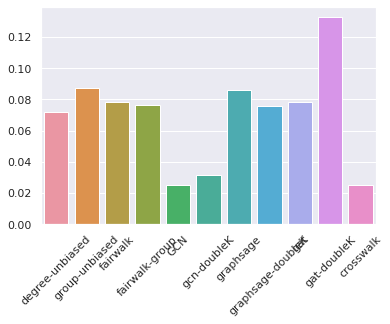

In [11]:
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(scores.keys()), y=list(scores.values()))
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)

In [12]:
# from utils.score import opportunity_difference
# scores = {}
# for k, graph in rgraphs.items():
#     # we will have to change group ids as well.
#     edges = list(nx.to_edgelist(graph))
#     edges = pd.DataFrame({
#         'source': [i[0] for i in edges],
#         'target': [i[1] for i in edges]
#     })
#     scores[k] = opportunity_difference(edges, group_ids)
#     print("class score: ", k, scores[k])

In [13]:
# sns.set(rc = {'figure.figsize':(15,8)})
# ax = sns.barplot(x=list(scores.keys()), y=list(scores.values()))
# ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)